class

inputs:
- Treatment data (8760) (data + model uncertainty)
- Comparison group data (8760) (data + model uncertainty)
- df_cg
- df_t_coeffs
- Settings

Settings
- outlier_removal bool
- ratio_weight
- uncertainty confidence level
- outlier rejection level - outlier_std
- solar_cap
- type of correction (None, "Ordinary DiD", "Pct DiD", "Abs Pct DiD")

correction func = (m_T - o_T) - scale_fcn(m_T, m_CG, o_T, o_CG)*(m_CG - o_CG)



In [ ]:
# do we need to be able to generate the SAME EXACT numbers (me and Caleb don't want to)

In [ ]:
# when do we aggregate? Does CG come in aggregated or do we do it here?
def unit_correction(oT, mT, oCG, mCG, settings):

    if settings.method is None:
        scale = 0
    
    elif settings.method == "ordinary_difference_in_differences":
        scale = 1

    elif settings.method == "percent_difference_in_differences":
        # simplified
        # savings = mT*oCG/mCG - oT 

        scale = mT/mCG

    elif settings.method == "absolute_percent_difference_in_differences":
        # simplified
        # savings = mT(1 - np.sign(mT)*np.sign(mCG) + oCG/mCG) - oT

        scale = np.abs(mT/mCG)

    correction = scale*(mCG - oCG)

    # outlier rejection

    if settings.agg == "mean":
        correction_agg = np.mean(correction)

    elif settings.agg == "median":
        correction_agg = np.median(correction)

    # [avg_cg_o1, .9,
    #  avg_cg_o2, .01]
    #    cg_o2, .01]

    # uncertainty

    return correction


def unit_cluster(oCG, oT, settings):
    if settings.agg == "mean":
        agg_fcn = np.mean
    else:
        agg_fcn = np.median

    


# if we can not repeat calculations with treatment meters then skip
def _corrected_model(treatment_data, comparison_data, df_cg, df_t_coeffs, Settings):
    # treatment_data = [id, observed, model] # for a single unit of time
    # comparison_data = [id, observed, model] # for a single unit of time

    return "1 unit corrected model"

def _corrected_model_dec(args):
    return _corrected_model(*args)

def _comparison_group_data(comparison_data, df_cg):
    #aggregate comparison group data based on df_cg
    return "full time period cg"

def mp_fcn():
    if mp:
        pass
    else:
        pass

    return

class Model_Corrected:
    def __init__(self, settings):
        self.settings = settings

    def 

class Savings:
    def __init__(self, settings):
        self.settings = settings

    def base_savings(self):
        return _corrected_model()

    def agg_savings(self):
        pass

In [ ]:
# transform:


mu, sigma = robust_mu_sigma(x, robust_type, c=1.5, tol=1e-08)
x_std = (x - mu)/sigma



x_std = bisymlog_transform(x, rescale_quantile=0.10)



x_std = robust_YJ_transform(x, Q_perc=0.25, c=c, outlier_alpha=outlier_alpha, robust_type=robust_type)

x_std = scipy_YJ_transform(x, robust_type=robust_type)

x_outliers = IQR_outlier(x_std, weights=weight, sigma_threshold=3, quantile=0.25)

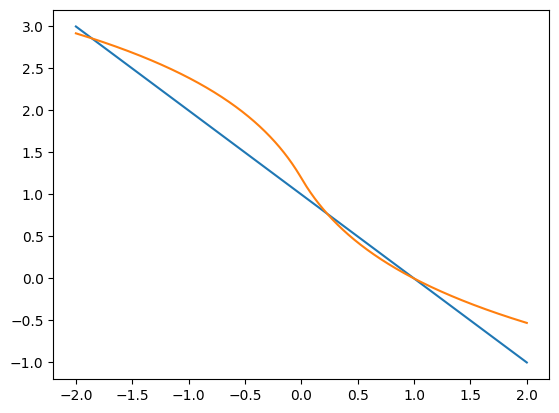

In [127]:
import numpy as np
import matplotlib.pyplot as plt

def bisymlog(x, C=None):
    if C is None:
        C = 1/np.log(10)

    return np.sign(x)*(np.log10(1 + np.abs(x/C)))*np.log(10)

x = np.linspace(-2, 2, 1000)
y = np.ones_like(x)*1

rel_err = (y-x)/y
C = None
log_err = bisymlog(y, C) - bisymlog(x, C)

# plot log error and relative error
plt.plot(x, rel_err)
plt.plot(x, log_err)
plt.show()

In [120]:
1/np.log(10)

0.43429448190325187

In [ ]:
def get_cg_ratio_beam(
    # this is coming in per hour for an individual cluster
    obs: np.ndarray,
    model: np.ndarray,
    ratio_weight: str,  # TODO: this should be in the settings
    outlier_removal: bool,
    alpha: float,
    outlier_std: float,
    solar_cap: float = 3.0,  # TODO: Add to cg settings
    model_unc_type=None,  # ["CI", None] TODO: Delete once the model_uncertainty below is being used
    model_uncertainty: (
        np.ndarray | None
    ) = None,  # TODO: pass in the model RMSE values here.
) -> tuple[float, float, list[int]]:
    """
    Returns the comparison group correction factor component (used later in conjunction with uncorrected counterfactual)
    for a single hour based on all the used CG records for a given comparison group and the metering+ settings.

    Inputs:
    obs - Observed values in a single hour for all members of the comparison group
    model - Model values in a single hour for all members of the comparison group
    ratio_weight - Whether to do a weighted or unweighted average calculation
    outlier removal - Whether to remove outliers from the calculation
    alpha - (1-CI) where CI is the confidence interval desired for the
            uncertainty calculation
    outlier_std: The standard deviation at which to remove outliers
    solar_cap: The maximum absolute value of the correction factor
               (which we want to cap for solar customers with very small
                loads). Default: 3.0. Cannot be None.
    model_unc_type: NOTE: model_unc_type is currently ignored (March 2023).
                    It remains for now until we are able to pass the model RMSE
                    in to the model_uncertainty keyword when this function is called.
                    Then the model_unc_type keyword can be removed.
    model_uncertainty: Numpy array containint the uncorrected model RMSE of all of the
                       meters making up the comparison group

    Returns:
    Tuple of (cg_correction_factor, cg_corr_factor_uncertainty, list_of_used_indices)
    IMPORTANT
    the returned used index array does not contain True/False values for which indices are used
    but rather ONLY the indices of values that were used.

    """
    # Component cap is subtracted by 1 because the component is oriented around zero, not 1.
    component_cap = solar_cap - 1

    Choice.RatioWeight.raise_error_if_value_not_in_choices_or_return(ratio_weight)
    if model_uncertainty is None:
        model_uncertainty = 0
    # check same length
    if np.shape(obs) != np.shape(model):
        raise Exception("obs and model must be same length in 'get_cg_ratio_beam'")

    # drop nonfinite rows
    idx_finite = idx_used = np.argwhere(
        np.isfinite(obs) & np.isfinite(model) & (obs != None) & (model != None)
    ).flatten()

    obs = obs[idx_finite]
    model = model[idx_finite]
    cg_correction_factor_component = (obs - model) / np.abs(model)

    length_err_value = _cg_correction_factor_length_check(
        cg_correction_factor_component=cg_correction_factor_component,
        index_valid=idx_used,
        component_cap=component_cap,
        model=model,
    )

    if length_err_value is not None:
        return length_err_value

    # TODO: add in weighting by treatment group?
    if outlier_removal:
        idx_valid = apply_cg_ratio_outlier_rejection(
            cg_correction_factor_component, outlier_std
        )
        cg_correction_factor_component = cg_correction_factor_component[idx_valid]
        obs = obs[idx_valid]
        model = model[idx_valid]
        idx_used = idx_used[idx_valid]

    length_err_value = _cg_correction_factor_length_check(
        cg_correction_factor_component=cg_correction_factor_component,
        index_valid=idx_used,
        component_cap=component_cap,
        model=model,
    )

    if length_err_value is not None:
        err_cf, err_unc, _ = length_err_value
        return err_cf, err_unc, list(idx_used.astype(int))

    # type hinter is saying all these are possibly unbounded further below.
    # setting them here and checking and raising error later to avoid static analysis errors
    solar_cap_applied = False
    if ratio_weight == Choice.RatioWeight.WEIGHT_BY_USAGE_MAGNITUDE:
        # ask travis about weight here, what happens with negative reads?
        weight = np.abs(model) / np.sum(np.abs(model))

        cg_correction_factor_component_mean = np.average(
            cg_correction_factor_component, weights=weight
        )
        # With the weights as defined in the weighted case above, the previous line is
        # equivalent to cg_correction_factor_mean = np.mean(obs)/np.mean(model).

        # Apply the solar cap to the weighted average in places
        # where the average of the model is "small" and there
        # is a risk of a catastrophic blowup.

        # TODO: figure out if solar cap still needed and if so where to apply
        if np.abs(np.mean(model)) < _CAP_MODEL_THRESHOLD:
            unclipped_mean = cg_correction_factor_component_mean
            cg_correction_factor_component_mean = np.clip(
                cg_correction_factor_component_mean, -component_cap, component_cap
            )
            solar_cap_applied = unclipped_mean != cg_correction_factor_component_mean

        # Kish's effective sample size, weights normalized https://doi.org/10.1002/bimj.19680100122
        n = 1 / np.sum(np.power(weight, 2))

        if n < 2:
            return (
                cg_correction_factor_component_mean,
                np.nan,
                list(idx_used.astype(int)),
            )

    elif ratio_weight == Choice.RatioWeight.NO_WEIGHT:
        weight = None
        n = len(cg_correction_factor_component)

        # Clip the individual correction factors at +/- the cap
        # before taking the unweighted average
        clipped = np.clip(cg_correction_factor_component, -component_cap, component_cap)
        # Apply the cap where the model is "small"
        # and there is a risk of having it blow up catastrophically.

        # TODO: figure out if solar cap still needed and if so where to apply
        # solar_cap_applied = list(clipped) != list(cg_correction_factor_component)
        cg_correction_factor_component_mean = np.average(
            np.where(
                np.abs(model) < _CAP_MODEL_THRESHOLD,
                clipped,
                cg_correction_factor_component,
            )
        )
        solar_cap_applied = cg_correction_factor_component_mean != np.average(
            cg_correction_factor_component
        )

    else:
        raise ValueError(
            f"ratio_weight {ratio_weight} not implemented in correction factor calc"
        )

    # Calculate the uncertainty of the correction factor
    # Note that this calculation only occurs over nonnegative weights.
    # because the calculation isn't sensible for negative weights.
    cg_correction_factor_mean_unc = np.nan
    if not solar_cap_applied:
        cg_correction_factor_std = fast_std(
            cg_correction_factor_component,
            mean=cg_correction_factor_component_mean,
            weights=weight,
        )
        cg_correction_factor_mean_unc = np.sqrt(
            np.average(
                (cg_correction_factor_component * model_uncertainty / model) ** 2,
                weights=weight,
            )
            + cg_correction_factor_std**2
        ) * unc_factor(n, interval="CI", alpha=alpha)

    return (
        cg_correction_factor_component_mean,
        cg_correction_factor_mean_unc,
        list(idx_used.astype(int)),
    )